# Provincial indicators 2020: analysis

# Table of contents

1. [Imports](#1)
2. [Load data and 2D scatterplot](#2) <br>
3. [Kolmogorov-Smirnov tests](#3) <br>
    3a. [Provincial prevalence](#3a) <br>
    3b. [Week provincial trend](#3b) <br>
4. [Correlation between variables](#4)
5. [OLS regression models](#5) <br>
6. [Standardization and final dataset](#6)
7. [Cluster analysis](#7) <br>
    7a. [Hierarchical clustering](#7a) <br>
    7b. [K-means](#7b) <br>

## Brief introduction
In this notebook we analyze the indicators for the provinces from the year 2020. <br> In particular we performed a cluster analysis first of all by using the Hierarchical clustering using Ward's method and then K-Means algorithm. <br>
Before that we analyzed hypothesis of normality and linearity and we performed an OLS regression.

<a id='1'></a>
## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from save_dataframes import save_dataframes

#PLOTS
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#OLS
import statsmodels.api as sm
from patsy import dmatrices

#HIERARCHICAL CLUSTERING
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
RESULT = "../results"
IMAGES = "../images"
DATA = "../DATA"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.cluster import AgglomerativeClustering

<a id='2'></a>
## 2. Load data and 2D scatterplot

We first load our provincial indicators:

In [2]:
provinces_indicators_2020=pd.read_csv("../Results/provinces_indicators_2020.csv")
provinces_indicators_2020.head()

Province_name  Provincial_prevalence  Week_provincial_trend
0     Agrigento            5019.599139               0.010120
1   Alessandria           40639.246755               1.355693
2        Ancona           20230.056198               0.064178
3         Aosta           51278.932130               0.411317
4        Arezzo           21738.292076               0.130570

We create a summary statistics table:

In [3]:
provinces_indicators_2020.describe()

Provincial_prevalence  Week_provincial_trend
count             107.000000             107.000000
mean            23735.945186               0.285225
std             13125.544460               0.364283
min              4813.366513               0.008474
25%             13442.797861               0.041983
50%             20630.781387               0.136840
75%             32920.115016               0.424869
max             62157.495757               2.309191

We will plot one point for each of the italian provinces:

In [4]:
labels=provinces_indicators_2020["Province_name"].unique()
print(labels)

['Agrigento' 'Alessandria' 'Ancona' 'Aosta' 'Arezzo' 'Ascoli Piceno'
 'Asti' 'Avellino' 'Bari' 'Barletta-Andria-Trani' 'Belluno' 'Benevento'
 'Bergamo' 'Biella' 'Bologna' 'Bolzano' 'Brescia' 'Brindisi' 'Cagliari'
 'Caltanissetta' 'Campobasso' 'Caserta' 'Catania' 'Catanzaro' 'Chieti'
 'Como' 'Cosenza' 'Cremona' 'Crotone' 'Cuneo' 'Enna' 'Fermo' 'Ferrara'
 'Firenze' 'Foggia' 'Forlì-Cesena' 'Frosinone' 'Genova' 'Gorizia'
 'Grosseto' 'Imperia' 'Isernia' "L'Aquila" 'La Spezia' 'Latina' 'Lecce'
 'Lecco' 'Livorno' 'Lodi' 'Lucca' 'Macerata' 'Mantova' 'Massa Carrara'
 'Matera' 'Messina' 'Milano' 'Modena' 'Monza e della Brianza' 'Napoli'
 'Novara' 'Nuoro' 'Oristano' 'Padova' 'Palermo' 'Parma' 'Pavia' 'Perugia'
 'Pesaro e Urbino' 'Pescara' 'Piacenza' 'Pisa' 'Pistoia' 'Pordenone'
 'Potenza' 'Prato' 'Ragusa' 'Ravenna' 'Reggio di Calabria'
 "Reggio nell'Emilia" 'Rieti' 'Rimini' 'Roma' 'Rovigo' 'Salerno' 'Sassari'
 'Savona' 'Siena' 'Siracusa' 'Sondrio' 'Sud Sardegna' 'Taranto' 'Teramo'
 'Terni' 'Torin

Wecreate our scatterplot:

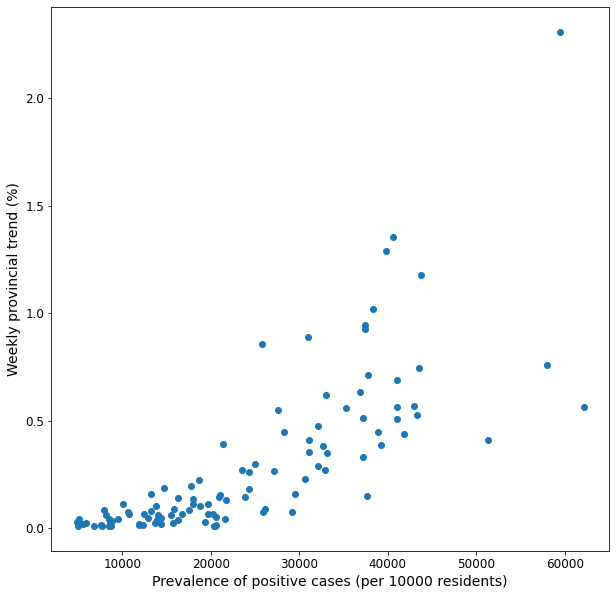

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = provinces_indicators_2020.iloc[:,1],
           y = provinces_indicators_2020.iloc[:,2])
plt.xlabel('Prevalence of positive cases (per 10000 residents)')
plt.ylabel("Weekly provincial trend (%)")

plt.savefig("../plots/2d_scatterplot_provinces_2020.pdf",bbox_inches="tight")

<a id='3'></a>
## 3. Kolmogorov-Smirnov tests

As in the paper, Kolmogorv-Smirnov tests for normality are done (H0: distribution equal to a standard Normal).

<a id='3a'></a>
### 3a. Provincial prevalence

We check the normality assumption with respect to a standardized Normal distribution:

In [6]:
normtest = stats.kstest(provinces_indicators_2020["Provincial_prevalence"],"norm") #0.0
print("The p-value is",normtest[1])

The p-value is 0.0


The null hypothesis is rejected. Hence we test with respect to a Gaussian distribution (not standardized).

In [7]:
data=provinces_indicators_2020["Provincial_prevalence"]
normed_data=(data-data.mean())/data.std()
std_normtest = stats.kstest(normed_data,"norm") #standardized: do not reject!
print("The p-value is",std_normtest[1]) #0.12710683934525657

The p-value is 0.12710683934525657


Hypothesis not rejected.

<a id='3b'></a>
### 3b. Week provincial trend

In [8]:
normtest=stats.kstest(provinces_indicators_2020["Week_provincial_trend"],"norm") #reject
print("The p-value is",normtest[1]) #1.2749758518444773e-25

The p-value is 1.2749758518444773e-25


The null hypothesis is rejected. Hence we proceed by considering the scaled data.

In [9]:
data=provinces_indicators_2020["Week_provincial_trend"]
normed_data=(data-data.mean())/data.std()
std_normtest =stats.kstest(normed_data,"norm") 
print("The p-value is",std_normtest[1]) #3.473211323436712e-05

The p-value is 3.473211323436712e-05


The null hypothesis is still rejected.

<a id='4'></a>
## 4. Correlation between indicators

We use a Spearman's rank correlation test to test if the indicators are correlated.
H0: the variables are uncorrelated

We test the correlation between provincial prevalence and week provincial trend:

In [10]:
corrtest=stats.spearmanr(provinces_indicators_2020["Provincial_prevalence"],provinces_indicators_2020["Week_provincial_trend"], axis=0, nan_policy="omit")
print("The correlation is",corrtest[0], "and the associated p-value is",corrtest[1] )

The correlation is 0.8532886616117088 and the associated p-value is 1.8368203925362956e-31


We rejct the null hypothesis of uncorrelation and we see that there is a positive strong correlation.

<a id='5'></a>
## 5. OLS regression models

Now we do a linear regression model of week provincial trend performed against the provincial prevalence.

We log-transform the variables and output a summary statistics and we create the design matrices:

In [11]:
logPrevalence=np.log(provinces_indicators_2020["Provincial_prevalence"])
logPrevalence.describe()

count    107.000000
mean       9.905187
std        0.614869
min        8.479152
25%        9.506094
50%        9.934539
75%       10.401837
max       11.037427
Name: Provincial_prevalence, dtype: float64

In [12]:
logTrend=np.log(provinces_indicators_2020["Week_provincial_trend"])
logTrend.describe()

count    107.000000
mean      -2.081945
std        1.417895
min       -4.770741
25%       -3.171423
50%       -1.988941
75%       -0.856476
max        0.836897
Name: Week_provincial_trend, dtype: float64

In [13]:
#Design matrix
logPrevalence,logTrend=dmatrices("Provincial_prevalence ~ Week_provincial_trend",data=provinces_indicators_2020,return_type="dataframe")

Now we can create and fit the model:

In [14]:
mod1=sm.OLS(logPrevalence,logTrend)

In [15]:
print("Degrees of freedom of the model:",mod1.df_model)
print("Degrees of freedom of the residuals:",mod1.df_resid)
print("Endogeneous variable:",mod1.endog_names)
print("Exogenous variable:",mod1.exog_names)

Degrees of freedom of the model: 1.0
Degrees of freedom of the residuals: 105.0
Endogeneous variable: Provincial_prevalence
Exogenous variable: ['Intercept', 'Week_provincial_trend']


We fit the model and check teh regression coefficients:

In [16]:
res1=mod1.fit() 
res1.params

Intercept                15880.121632
Week_provincial_trend    27542.532615
dtype: float64

We print a summary of the model:

In [17]:
 res1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Provincial_prevalence   R-squared:                       0.584
Model:                               OLS   Adj. R-squared:                  0.580
Method:                    Least Squares   F-statistic:                     147.6
Date:                   Thu, 16 Sep 2021   Prob (F-statistic):           9.75e-22
Time:                           21:14:55   Log-Likelihood:                -1119.0
No. Observations:                    107   AIC:                             2242.
Df Residuals:                        105   BIC:                             2247.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.588e+04   1045.837     15.184      0.000    1.38e+04     1.8e+04
Week_provincial_trend  2.754e+04   2267.058     12.149      0.000     2.3e+04     3.2e+04
==============================================================================
Omnibus:                       12.994   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.497
Skew:                           0.732   Prob(JB):                     0.000711
Kurtosis:                       4.054   Cond. No.                         3.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We test the linearity of the parameters through a Rainbow test:

In [18]:
print("F-test statistic:",sm.stats.linear_rainbow(res1)[0],", p-value:",sm.stats.linear_rainbow(res1)[1])

F-test statistic: 0.9925183544491931 , p-value: 0.5118486656156902


We do not reject the null hypothesis.

<a id='6'></a>
## 6. Standardization and final dataset

We standardize the variables since we have different measurement scales:

In [19]:
provinces_indicators_2020["z1_mod"]=(logPrevalence - np.nanmean(provinces_indicators_2020["Provincial_prevalence"]))/np.nanstd(provinces_indicators_2020["Provincial_prevalence"])
provinces_indicators_2020["z2_mod"]=(logTrend.iloc[:,1] - np.nanmean(provinces_indicators_2020["Week_provincial_trend"]))/np.nanstd(provinces_indicators_2020["Week_provincial_trend"])
provinces_indicators_2020

Province_name  Provincial_prevalence  Week_provincial_trend    z1_mod  \
0        Agrigento            5019.599139               0.010120 -1.432659   
1      Alessandria           40639.246755               1.355693  1.293878   
2           Ancona           20230.056198               0.064178 -0.268361   
3            Aosta           51278.932130               0.411317  2.108301   
4           Arezzo           21738.292076               0.130570 -0.152912   
..             ...                    ...                    ...       ...   
102       Vercelli           38904.421749               0.446982  1.161084   
103         Verona           32069.009518               0.475808  0.637861   
104  Vibo Valentia            4813.366513               0.027701 -1.448445   
105        Vicenza           27168.024674               0.265572  0.262711   
106        Viterbo           17565.196340               0.083004 -0.472345   

       z2_mod  
0   -0.758750  
1    2.952387  
2   -0.609656  
3    0.347765  
4   -0.426544  
..        ...  
102  0.446131  
103  0.525635  
104 -0.710261  
105 -0.054204  
106 -0.557733  

[107 rows x 5 columns]

In [20]:
provinces_indicators_2020.z1_mod.describe()

count    1.070000e+02
mean    -4.321569e-16
std      1.004706e+00
min     -1.448445e+00
25%     -7.878977e-01
50%     -2.376874e-01
75%      7.030101e-01
max      2.941010e+00
Name: z1_mod, dtype: float64

In [21]:
provinces_indicators_2020.z2_mod.describe()

count    1.070000e+02
mean     1.265862e-16
std      1.004706e+00
min     -7.632891e-01
25%     -6.708718e-01
50%     -4.092506e-01
75%      3.851429e-01
max      5.582169e+00
Name: z2_mod, dtype: float64

Dataframe with scaled values to be used in the clustering analysis:

In [22]:
data_scaled_province=provinces_indicators_2020[["z1_mod","z2_mod"]]
data_scaled_province

z1_mod    z2_mod
0   -1.432659 -0.758750
1    1.293878  2.952387
2   -0.268361 -0.609656
3    2.108301  0.347765
4   -0.152912 -0.426544
..        ...       ...
102  1.161084  0.446131
103  0.637861  0.525635
104 -1.448445 -0.710261
105  0.262711 -0.054204
106 -0.472345 -0.557733

[107 rows x 2 columns]

And we save the dataframe

In [23]:
save_dataframes(data_scaled_province,"../Results/scaled_province_data2020.csv")

<a id='7'></a>
## 7. Cluster Analysis

<a id='7a'></a>
### 7a. Hierarchical clustering

We first visualize the data

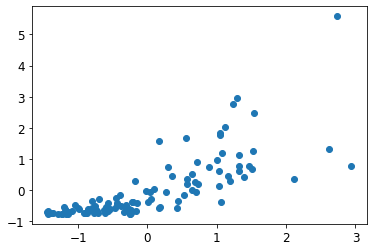

In [24]:
plt.scatter(data_scaled_province["z1_mod"], data_scaled_province["z2_mod"])

Next we create a dendogram in order to do a hierarchical clustering analysis:

In [25]:
##Here we stored first the distances between the points
dist=sklearn.metrics.pairwise.euclidean_distances(data_scaled_province, squared=True) 

In [26]:
labels=provinces_indicators_2020["Province_name"].to_list()

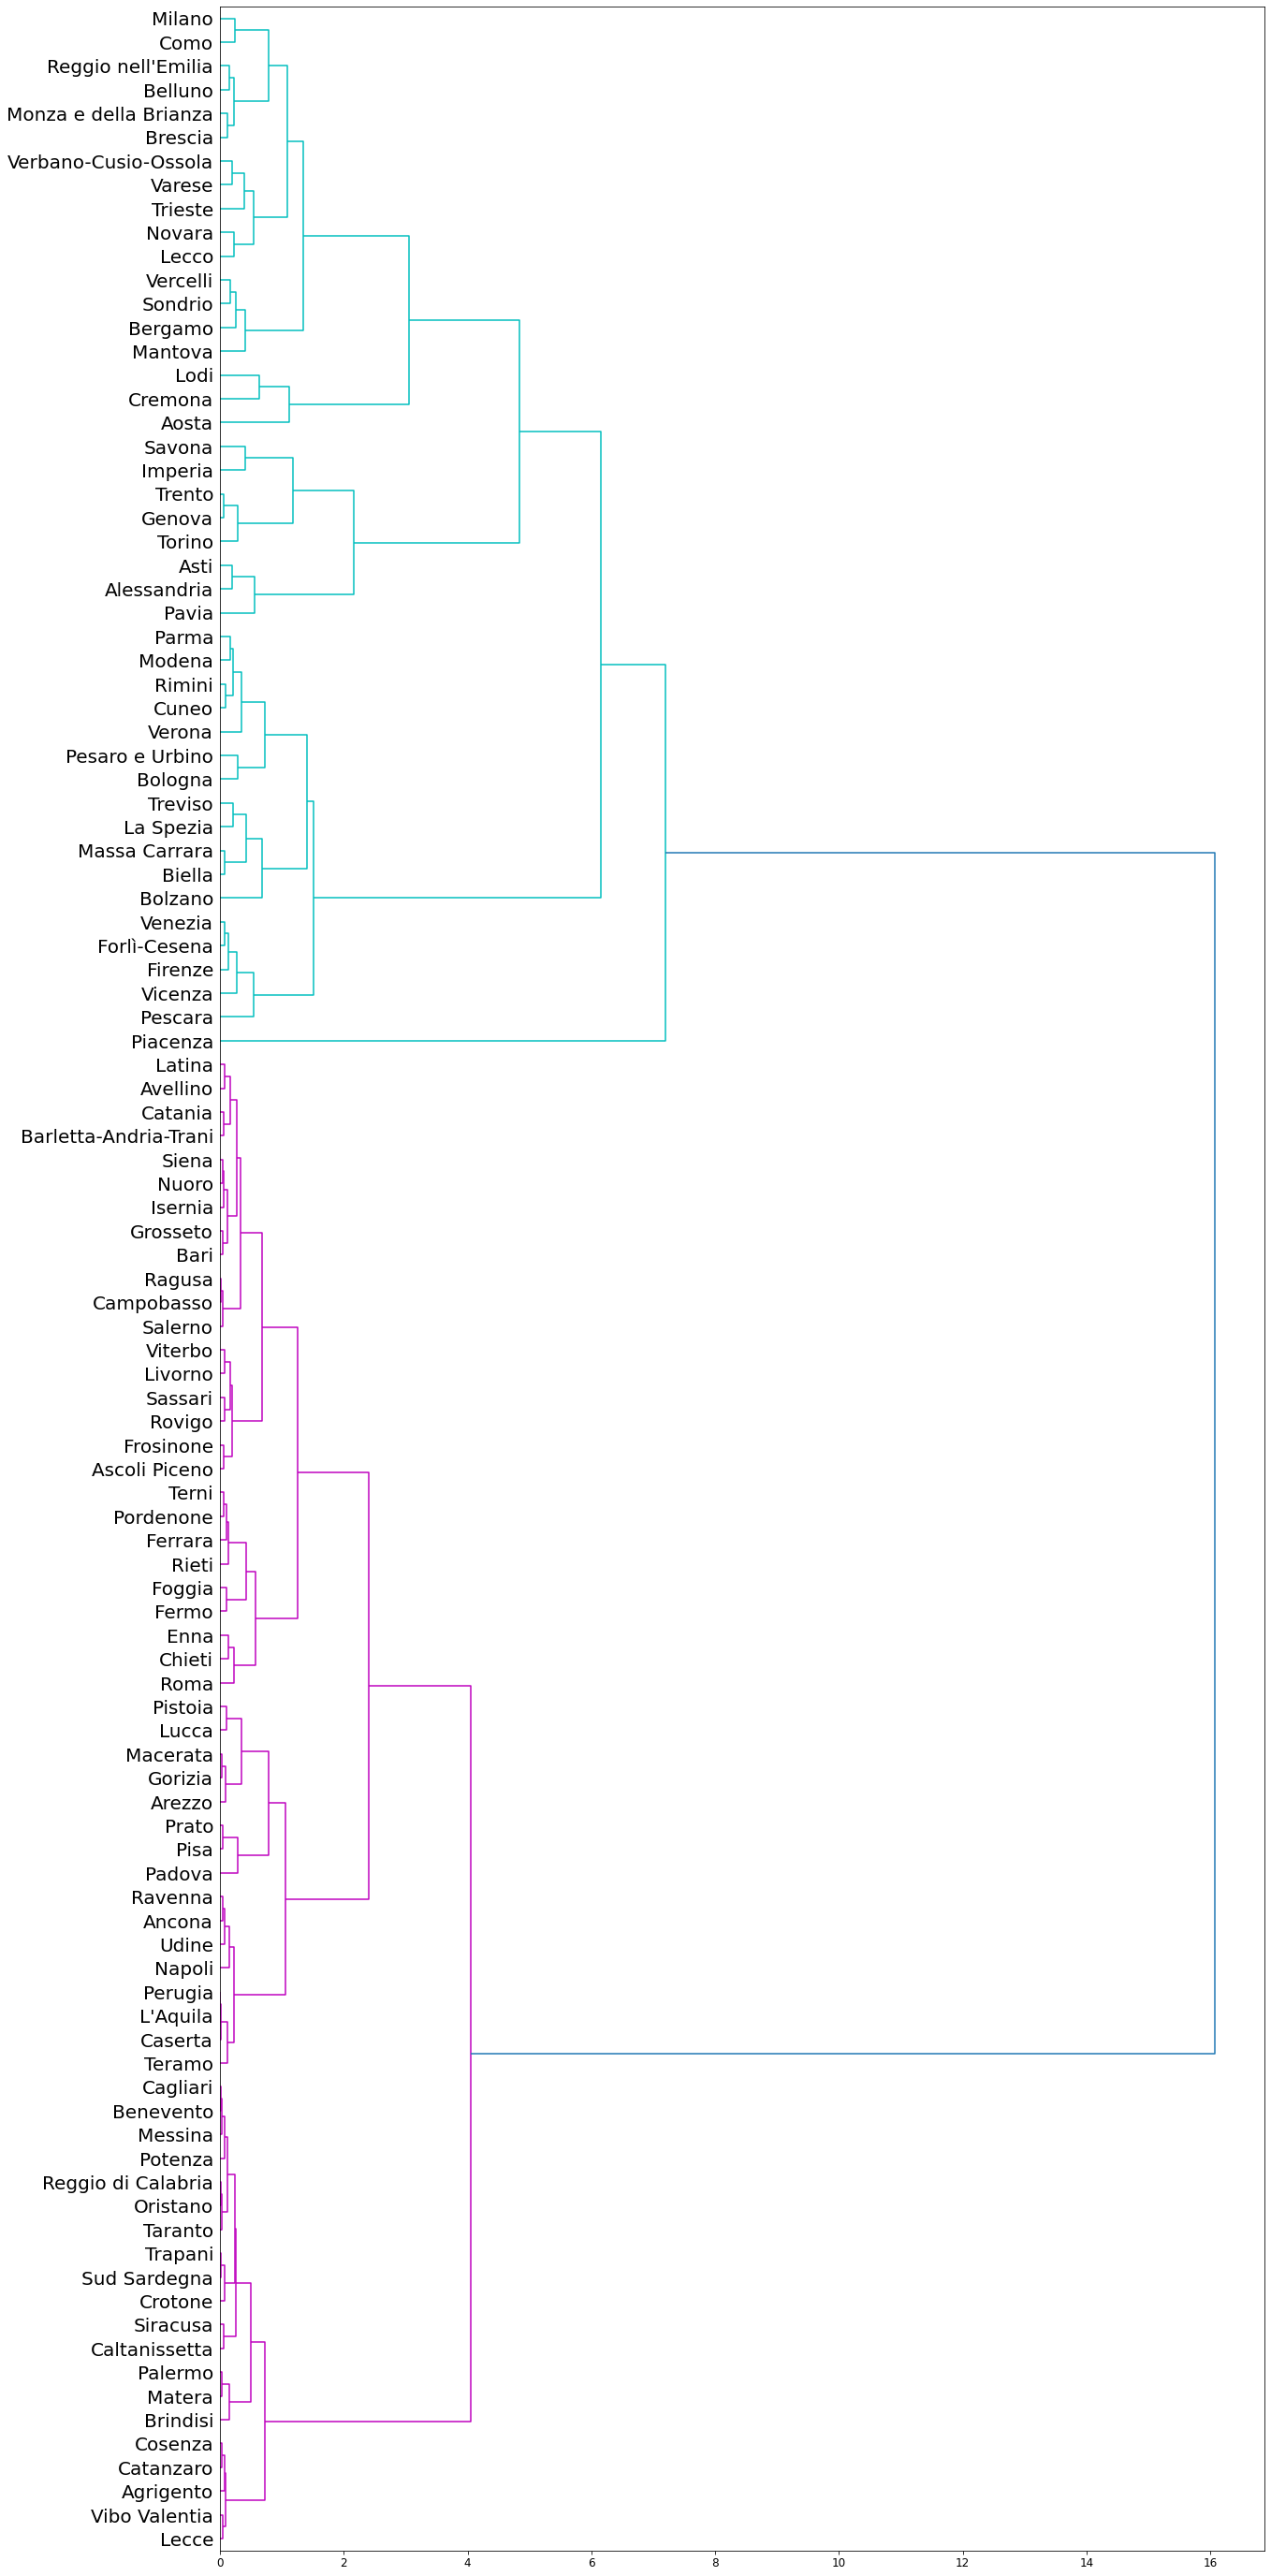

In [27]:
shc.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.figure(figsize=(20, 50))
dendrogram(shc.linkage(data_scaled_province, method="ward"),
            orientation='right',
            labels=labels,
            distance_sort='descending',
            show_leaf_counts=True)

ax=plt.gca()
ax.tick_params(axis='y', which='major', labelsize=20)

plt.savefig("../plots/provincial_dendogram_2020.pdf",bbox_inches="tight")
plt.show()

We check what is the optimal number of clusters by computing the average silhouette width:

In [28]:
range_n_clusters = range(4,19)

for n_clusters in range_n_clusters:

    clusterer =AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage='ward') 
    cluster_labels = clusterer.fit_predict(data_scaled_province)

    silhouette_avg = silhouette_score(data_scaled_province, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 4 The average silhouette_score is : 0.4492317271993204
For n_clusters = 5 The average silhouette_score is : 0.4807099375837891
For n_clusters = 6 The average silhouette_score is : 0.4157141317938369
For n_clusters = 7 The average silhouette_score is : 0.4249078090446717
For n_clusters = 8 The average silhouette_score is : 0.4107420813237329
For n_clusters = 9 The average silhouette_score is : 0.41527954596636135
For n_clusters = 10 The average silhouette_score is : 0.4081207005908459
For n_clusters = 11 The average silhouette_score is : 0.40575658284898714
For n_clusters = 12 The average silhouette_score is : 0.3967776515492996
For n_clusters = 13 The average silhouette_score is : 0.39132339602760396
For n_clusters = 14 The average silhouette_score is : 0.3949839074443533
For n_clusters = 15 The average silhouette_score is : 0.393518188229182
For n_clusters = 16 The average silhouette_score is : 0.4041831349069658
For n_clusters = 17 The average silhouette_score is : 0

The optimal number of clusters seems to be 5, hence we apply hierarchical clustering for 5 clusters and then visualize the scatterplots with the created clusters:

In [29]:
cluster = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage='ward')  
preds=cluster.fit_predict(data_scaled_province)
preds

array([0, 4, 0, 1, 0, 0, 4, 0, 0, 0, 1, 0, 1, 3, 3, 3, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 3, 0, 0, 0, 3, 0, 3, 0, 4, 0, 0, 4, 0, 0, 3,
       0, 0, 1, 0, 1, 0, 0, 1, 3, 0, 0, 1, 3, 1, 0, 1, 0, 0, 0, 0, 3, 4,
       0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 4, 0, 0,
       1, 0, 0, 0, 0, 4, 0, 4, 3, 1, 0, 1, 3, 1, 1, 3, 0, 3, 0],
      dtype=int64)

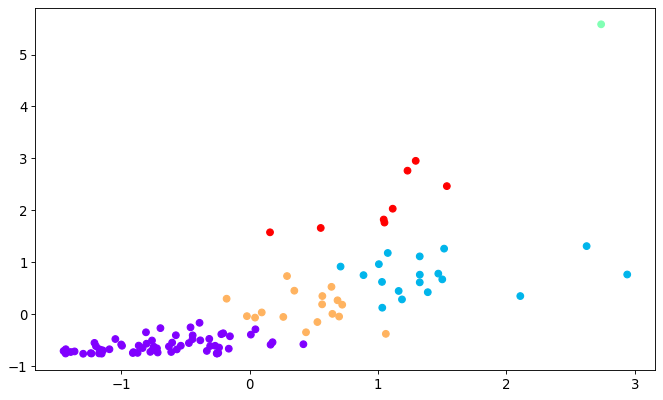

In [30]:
plt.figure(figsize=(10,6), dpi=80)
ax=plt.scatter(data_scaled_province["z1_mod"],data_scaled_province["z2_mod"], c=cluster.labels_, cmap='rainbow')

<a id='7b'></a>
### 7a. K-means

For the K-means algorithm the imports are:

In [31]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

%matplotlib inline

rnd_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

In [32]:
 X=data_scaled_province

We first look again to the scatterplot of the data:

Text(0, 0.5, 'Weekly provincial trend (%)')

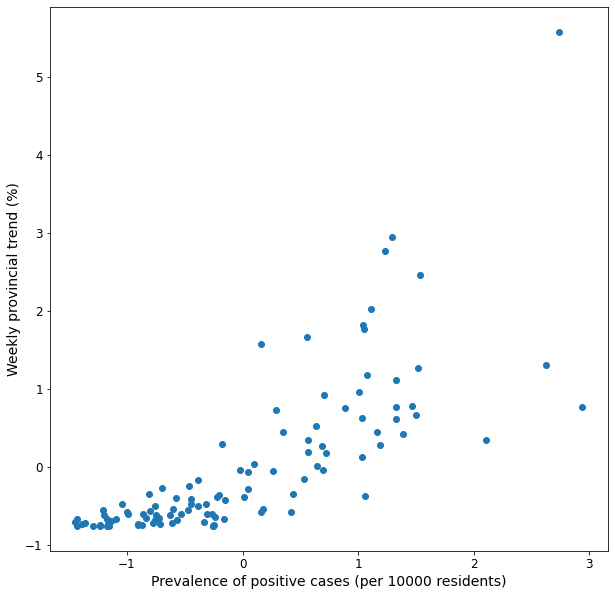

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x = data_scaled_province.iloc[:,0],
               y = data_scaled_province.iloc[:,1])
plt.xlabel('Prevalence of positive cases (per 10000 residents)')
plt.ylabel("Weekly provincial trend (%)")

We will check the inertia and the silhouette scores for 4 to 18 clusters:

In [34]:
k_range = range(4,19)

In [35]:
distortions = []
silhouette_scores = []
for i in k_range:
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=rnd_state)
    y_km = km.fit_predict(X)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X,y_km))

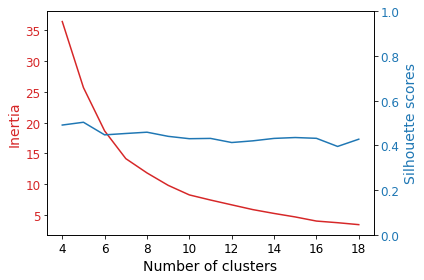

In [36]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

It seems that a good number of clusters could be of 5:

In [37]:
good_k = 5
km = KMeans(n_clusters=good_k, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=rnd_state)
y_km = km.fit_predict(X)
y_km

array([1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 3, 3, 3, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 3, 1, 1, 1, 3, 1, 3, 1, 2, 1, 1, 2, 1, 1, 3,
       1, 1, 0, 1, 0, 3, 1, 3, 3, 1, 1, 0, 3, 0, 1, 0, 1, 1, 3, 1, 3, 2,
       1, 3, 3, 4, 3, 3, 1, 1, 3, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 2, 1, 1,
       0, 1, 1, 1, 1, 2, 1, 2, 3, 0, 1, 0, 3, 0, 0, 3, 1, 3, 1])

We compute the cluster centers (centroids):

In [38]:
km.cluster_centers_

array([[ 1.44599797,  0.77607682],
       [-0.76796668, -0.61159881],
       [ 0.99792323,  2.12895825],
       [ 0.40168525, -0.01453958],
       [ 2.73795502,  5.58216917]])

After importing the function for plotting the clusters (Reference: Professor Claudio Sartori, Università di Bologna), we plot the obtained K-means clustering:

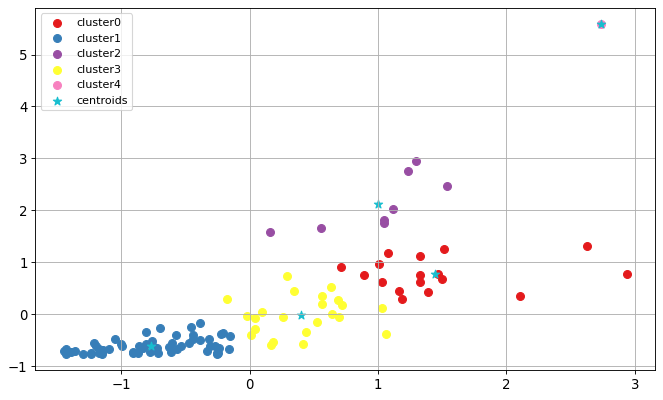

In [39]:
import plot_clusters as pc

pc.plot_clusters(X,y_km,dim=(0,1), points = km.cluster_centers_)
plt.savefig("../plots/k_means_province_2020.pdf",bbox_inches="tight")
plt.savefig('../img/k_means_province_2020.png', dpi=300,bbox_inches="tight")

plt.show()